<a href="https://colab.research.google.com/github/coderacheal/Alkebulan/blob/main/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117
%pip install transformers

Looking in indexes: https://download.pytorch.org/whl/cu117, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder


warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

df =  pd.read_csv('/content/drive/MyDrive/Colab Notebooks/dataset.csv')
df

In [4]:
df.shape

(937854, 3)

In [5]:
df['Language'].unique()

array(['en', 'es', 'ca', 'fr', 'pt', 'ja', 'hi', 'ar', 'ko', 'nl', 'et',
       'in', 'und', 'tl', 'zh', 'de', 'cs', 'ru', 'qme', 'it', 'el', 'ro',
       'no', 'tr', 'sv', 'ta', 'fa', 'ht', 'pl', 'da', 'th', 'hu', 'lv',
       'uk', 'qht', 'eu', 'qam', 'si', 'cy', 'zxx', 'ml', 'ne', 'mr',
       'qst', 'vi', 'bn', 'gu', 'is', 'fi', 'ckb', nan, 'te', 'art', 'bg',
       'ur', 'sl', 'lt', 'pa', 'iw', 'kn', 'sr',
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWV94O7UEAAjMOi?format=jpg&name=large')]",
       "[Photo(previewUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/FWWBzWTXkAAyZqm?format=jpg&name=large')]",
       'am', 'or',
       "[Photo(previewUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=small', fullUrl='https://pbs.twimg.com/media/EPYG2rKVAAA1e_O?format=jpg&name=large')]",
       'sd',
       "[Photo(previewUrl='h

In [6]:
english_df = df[df['Language'] =='en']
english_df = english_df[:100000]

In [7]:
english_df['Language'].unique()

array(['en'], dtype=object)

## EDA

In [8]:
english_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 107585
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Text      100000 non-null  object
 1   Language  100000 non-null  object
 2   Label     100000 non-null  object
dtypes: object(3)
memory usage: 3.1+ MB


In [9]:
sentiments = english_df['Label'].value_counts().sort_values(ascending=False)
sentiments

positive       28594
negative       28170
uncertainty    22546
litigious      20690
Name: Label, dtype: int64

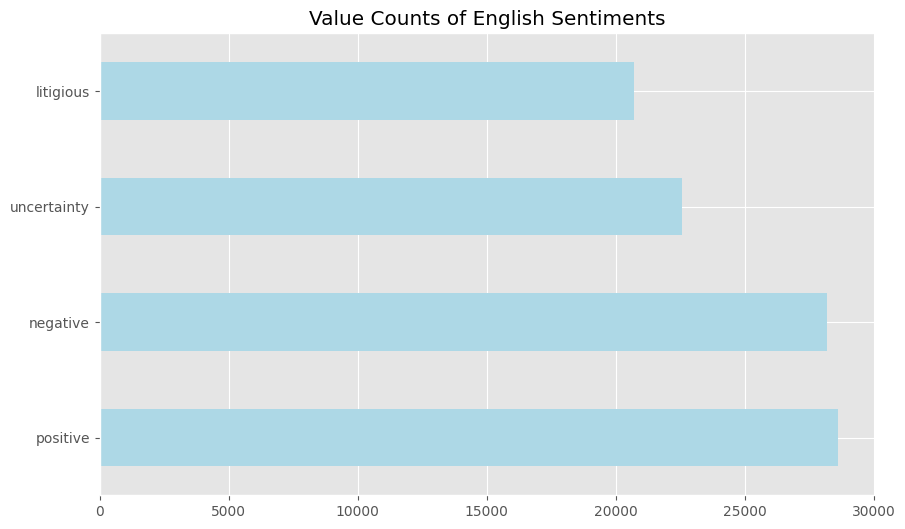

In [10]:
sentiments.plot(kind='barh', color='lightblue', figsize=(10,6))
plt.title('Value Counts of English Sentiments')
plt.show()

### Data Cleaning

1. Remove usernames from tweets
2. Remove hashtags from tweets
3. Remove things like http links and \n form tweet

##### Let's start with usernames

- We need to remove the usernames that follow the @ symbol. The symbol will be removed as well
- Write a function using the re module

In [11]:
# before
english_df['Text'][0]

'@Charlie_Corley @Kristine1G @amyklobuchar @StyleWriterNYC testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [12]:
def remove_usernames(text):
    pattern = r'@\w+\s?'
    result = re.sub(pattern, '', text)
    return result


english_df['Text'] = english_df['Text'].apply(remove_usernames)
english_df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative
...,...,...,...
107580,David Lammy under investigation for financial ...,en,litigious
107581,Did later years improve suspension vs early re...,en,positive
107583,i was thinking about this a lot when i helped ...,en,positive
107584,"The problem is not trust issues, but the work ...",en,negative


In [13]:
# after
english_df['Text'][0]

'testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination'

In [14]:
# corresponding label
english_df['Label'][0]

'litigious'

##### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [15]:
# before
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n#SovereignGroup #SovereignAfrica #UNDP #Rwanda'

In [16]:
def remove_hastags(text):
    pattern = r'#\w+\s?'
    result = re.sub(pattern, '', text)
    return result


english_df['Text'] = english_df['Text'].apply(remove_hastags)
english_df

,Text,Language,Label
0,"testimony is NOT evidence in a court of law, s...",en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative
...,...,...,...
107580,David Lammy under investigation for financial ...,en,litigious
107581,Did later years improve suspension vs early re...,en,positive
107583,i was thinking about this a lot when i helped ...,en,positive
107584,"The problem is not trust issues, but the work ...",en,negative


#### Next, hashtags

- We need to remove the hashtags that follow the @ symbol.
- Write a function using the re module

In [17]:
#after there are not more hashtags
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

##### Next, http links

- We need to remove all http links.
- Write a function using the re module

In [18]:
#before
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: https://t.co/BznkTC8pl0\n\n'

In [19]:
def remove_urls(string):
    pattern = r'https?://\S+'
    result = re.sub(pattern, '', string)
    return result

english_df['Text'] = english_df['Text'].apply(remove_urls)

In [20]:
#after
english_df['Text'][3]

'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n'


##### Remove special characters

- We need to remove * and newline characters (\n).
- Write a function using the re module

In [21]:
#before
english_df['Text'].unique()

array(['testimony is NOT evidence in a court of law, state or federal. Must stand up to cross examination',
       ' Flagstar Bank discloses a data breach that impacted 1.5\nMillion individuals ',
       'Rwanda is set to host the headquarters of United Nations Development Programme’s (UNDP) new innovation financing facility. \n\nFind out more: \n\n',
       ...,
       'i was thinking about this a lot when i helped build the first colored coin integration demo on lightning in 2016 pre-segwit :)\n\nif the issuer issues extra unbacked coins to make channel creation easier, you lose the auditability of stablecoins (observers can’t tell total supply)',
       'The problem is not trust issues, but the work overhead that comes with a sloppy decision like this to pay all the collections their share of royalties. I root that XP Network will find a good solution for this',
       'He’s also a perfect republican.'], dtype=object)

In [22]:
def remove_special_chars(text):
    pattern = r'[*\n]'
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

english_df['Text'] = english_df['Text'].apply(remove_special_chars)

In [23]:
#let's drop the language column

data = english_df
data.drop(columns='Language', inplace=True)
data

,Text,Label
0,"testimony is NOT evidence in a court of law, s...",litigious
2,Flagstar Bank discloses a data breach that im...,litigious
3,Rwanda is set to host the headquarters of Unit...,positive
4,OOPS. I typed her name incorrectly (today’s br...,litigious
5,It sucks for me since I'm focused on the natur...,negative
...,...,...
107580,David Lammy under investigation for financial ...,litigious
107581,Did later years improve suspension vs early re...,positive
107583,i was thinking about this a lot when i helped ...,positive
107584,"The problem is not trust issues, but the work ...",negative


# Let's Train a Bert Model with a quarter million Tweets

In [24]:
from torch.nn.utils.rnn import pad_sequence

#### Creating Tokenizer and Model

Let's convert our text and label column into list for easy splitting



In [25]:
X = data['Text'].to_list()
y = data['Label'].to_list()


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(y_train)



In [26]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and encode the training texts
train_encodings = tokenizer(X_train, truncation=True, padding=True)
train_labels = torch.tensor(train_labels)

In [27]:
# Tokenize and encode the test texts
test_encodings = tokenizer(X_test, truncation=True, padding=True)
test_labels = torch.tensor(label_encoder.transform(y_test))

In [28]:
# Create train and test datasets
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [29]:

train_dataset = SentimentDataset(train_encodings, train_labels)
test_dataset = SentimentDataset(test_encodings, test_labels)

In [30]:
#Create train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [31]:
# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
# Set device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [33]:
# Set training parameters
num_epochs = 1
optimizer = AdamW(model.parameters(), lr=1e-5)

In [34]:
for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

KeyboardInterrupt: ignored

In [ ]:
# Evaluation loop
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.argmax(dim=1).cpu().numpy().tolist())


### Create a Dataset class

In [ ]:
# class SentimentDataset(Dataset):
#     def __init__(self, texts, labels, tokenizer):
#         self.texts = texts
#         self.labels = labels
#         self.tokenizer = tokenizer
        

#     def __len__(self):
#         return len(self.texts)

    
    
# # Fit the label encoder on your labels to assign numerical values
#     # label_encoder.fit(self.labels)

#     def __getitem__(self, idx):
#       label_encoder = LabelEncoder()
#       label_encoder.fit(self.labels)
#       encoding = self.tokenizer(self.texts[idx], truncation=True, padding=True, return_tensors='pt')
#       label = torch.tensor(label_encoder.transform([self.labels[idx]]), dtype=torch.long)  # Apply label encoding
#       return encoding, label

    # def __getitem__(self, idx):
    #     encoding = self.tokenizer(self.texts[idx], truncation=True, padding=True, return_tensors='pt')
    #     label = torch.tensor(self.labels[idx], dtype=torch.long)
    #     return encoding, label

    # def __getitem__(self, idx):
    #     encoding = self.tokenizer(self.texts[idx], truncation=True, padding=True, return_tensors='pt')
    #     label = torch.tensor(int(self.labels[idx]), dtype=torch.long)  # Convert label to integer before creating the tensor
    #     return encoding, label





### Create tokenizer and model 

In [ ]:
# # Create train and test datasets
# def collate_fn(batch):
#     encodings, labels = zip(*batch)
#     padded_encodings = pad_sequence(encodings, batch_first=True)
#     padded_labels = pad_sequence(labels, batch_first=True)
#     return padded_encodings, padded_labels

# # Create train and test dataloaders


#     tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
#     model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

#     train_dataset = SentimentDataset(X_train, y_train, tokenizer)
#     test_dataset = SentimentDataset(X_test, y_test, tokenizer)

#     train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
#     test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

#     # train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#     # test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     optimizer = AdamW(model.parameters(), lr=1e-5)
#     num_epochs = 5

In [ ]:
# for epoch in range(num_epochs):
#     model.train()
#     for batch in train_dataloader:
#         input_ids = batch[0]['input_ids'].squeeze().to(device)
#         attention_mask = batch[0]['attention_mask'].squeeze().to(device)
#         labels = batch[1].to(device)
        
#         optimizer.zero_grad()
#         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()

